Imbalanced classification. Binary Classification. Sources.

- https://towardsdatascience.com/supervised-machine-learning-technique-for-anomaly-detection-logistic-regression-97fc7a9cacd4

- https://stats.stackexchange.com/questions/474640/is-anomaly-detection-supervised-or-un-supervised

- https://github.com/yzhao062/pyod

- https://www.analyticsvidhya.com/blog/2021/06/univariate-anomaly-detection-a-walkthrough-in-python/

- https://www.projectpro.io/article/anomaly-detection-using-machine-learning-in-python-with-example/555

- https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf

- https://www.machinelearningplus.com/statistics/mahalanobis-distance/

___

**In this section because of i will focus on models i will not implement feature selection, feature elimination or dimensionality reduction. But feature selection and hyperparameter optimization are must while preparing a machine learning model.**

If you have an imbalanced data(like 90000 labeled with 1 and 100 data labeled 0) you can look the links below.

- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

- https://www.kaggle.com/klaudiajankowska/binary-classification-multiple-method-comparison

- https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

- https://www.kaggle.com/satoshiss/titanic-binary-classification

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")
import time

In [2]:
df_train = pd.read_csv("feature_engineering_tools/df_train_model.csv")

In [3]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,-0.113551,2,51,7,-0.009889,-0.039310,-0.091223,-0.006301,-0.091933,-0.02622,...,-0.813985,-0.779157,-0.280673,0.073120,-0.287993,-0.641804,-0.627365,-0.221668,-0.374281,normal
1,-0.113551,3,33,7,-0.010032,-0.039310,-0.091223,-0.006301,-0.091933,-0.02622,...,-1.030895,-1.157831,2.764403,2.375620,-0.287993,-0.641804,-0.627365,-0.385140,-0.374281,normal
2,-0.113551,2,8,2,-0.010093,-0.039310,-0.091223,-0.006301,-0.091933,-0.02622,...,-0.804947,-0.935081,-0.173828,-0.478183,-0.287993,1.603834,1.614454,-0.385140,-0.374281,anomaly
3,-0.113551,2,61,7,-0.009996,0.052473,-0.091223,-0.006301,-0.091933,-0.02622,...,1.264742,1.069663,-0.440940,-0.380894,0.073759,-0.574435,-0.604947,-0.385140,-0.342768,normal
4,-0.113551,2,61,7,-0.010010,-0.034582,-0.091223,-0.006301,-0.091933,-0.02622,...,1.264742,1.069663,-0.440940,-0.478183,-0.287993,-0.641804,-0.627365,-0.385140,-0.374281,normal


Here i dont have to tackle with unbalance data because the data is not unbalanced but i will act like data is like that.

- https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

In [4]:
df_train["class"].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

Algorithms will use:

- Logistic Regression(If you are working on a textual dataset where the data is not very large then it is good)

- Stochastic Gradient Descent Classifier(If you are working on a large dataset of images then you have to use a very powerful classification algorithm.)

- Passive-Agressive(If you are working on a binary classification problem where the data arrives in a continuous flow)

- LightGBM

- Extra Trees

- Neural networks

- k-NN

- Naive Bayes

#### PREPARING DATA

**About Data**

39 columns, binary class(anomaly and normal), 20k rows.

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, \
roc_curve, roc_auc_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Divide train, test and validation sets equally. All of them have equal rate of class.

In [6]:
df_train2, df_holdout = train_test_split(df_train, test_size=0.1, stratify=df_train["class"])

In [7]:
df_test, df_val = train_test_split(df_holdout, test_size=0.5, stratify=df_holdout["class"])

___

In [8]:
# To compare models save the scores of each model to dictionary
compare_dictionary = {}

def model_evaluation(model, params, plot_cm=False, show_best_params=False, show_metrics=False):
    """
    A quick model evaluation. The time metric used here only for comparing the models' speed.
    """
    sample_time = time.time()
    
    model_name = model.__class__.__name__
    
    x_train, y_train = df_train2.drop("class", axis=1), df_train2["class"]
    cv_score = np.mean(cross_val_score(model, x_train, y_train, cv=5))
    model.fit(x_train, y_train)
    
    # I use df_test set to detect models hyperparameters. And i will make final evaluation on df_val.
    
    x_test, y_test = df_test.drop("class", axis=1), df_test["class"]
    random_cv = RandomizedSearchCV(model, params, n_iter=10, cv=5)
    random_cv.fit(x_test, y_test)
    
    best_estimator = random_cv.best_estimator_
    best_score_test = round(random_cv.best_score_, 3)
    best_params = random_cv.best_params_
    
    x_val, y_val = df_val.drop("class", axis=1), df_val["class"]
    best_score_val = np.round(best_estimator.score(x_val, y_val), 4)
    
    print(f"FOR MODEL {model_name}")
    print(f"Pure Test Score = {best_score_test}")
    print(f"Final score = {best_score_val}")
    
    if show_best_params:
        print(f"Best Parameters = {best_params}")
        
    if show_metrics:
        #precision recall f1 score, roc auc curve
        
        y_pred = model.predict(x_val)
        y_true = y_val.values

        y_pred = [1 if i=="normal" else 0 for i in y_pred]
        y_true = [1 if i=="normal" else 0 for i in y_true]
        
        print(f"Precision Score = {np.round(precision_score(y_pred, y_true),3)}\
\nRecall Score = {np.round(recall_score(y_pred, y_true),3)}\nF1 Score = {np.round(f1_score(y_pred, y_true),3)}")
        rocauc_score = np.round(roc_auc_score(y_true, y_pred),3)
        # How negative and positive classes divided good. If 1 best distinction, otherwise 0 worst distinction.
        print(f"Roc Auc Score = {rocauc_score}")
        
        fpr1, tpr1, thresh1 = roc_curve(y_true, y_pred)

        plt.plot(fpr1, tpr1, linestyle="--", color="black")
        plt.title(f"ROC Curve for {model_name}")
        plt.show()
        
    if plot_cm:
        y_pred = model.predict(x_val)
        y_true = y_val
        
        cm = confusion_matrix(y_pred, y_true)
        
        sns.heatmap(cm, annot=True, fmt=".3g")
        plt.title(f"Confusion Matrix for {model_name}")
        plt.show()
    
    time_spent = np.round((time.time() - sample_time),3)
    print(f"Time Spent = {time_spent}")
    compare_dictionary.update({model_name:{"final_score":best_score_val, "roc_auc_score":rocauc_score,
                                          "pure_score_wo_param":best_score_test,"time":time_spent}})

___

#### LOGISTIC REGRESSION

In [9]:
from sklearn.linear_model import LogisticRegression

FOR MODEL LogisticRegression
Pure Test Score = 0.956
Final score = 0.9548
Precision Score = 0.967
Recall Score = 0.96
F1 Score = 0.964
Roc Auc Score = 0.961


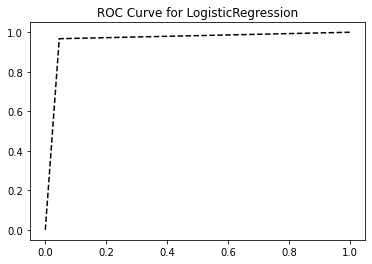

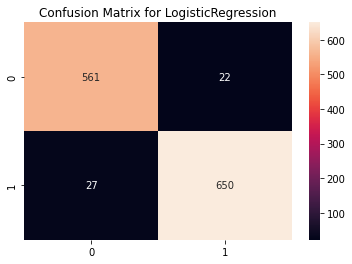

Time Spent = 3.225


In [10]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

params = {"C":C,"penalty":penalty}

log_reg = LogisticRegression()

model_evaluation(log_reg, params, plot_cm=True, show_metrics=True)

#### LIGHTGBM

In [11]:
import lightgbm as lgb

FOR MODEL LGBMClassifier
Pure Test Score = 0.992
Final score = 0.9913
Precision Score = 1.0
Recall Score = 0.993
F1 Score = 0.996
Roc Auc Score = 0.996


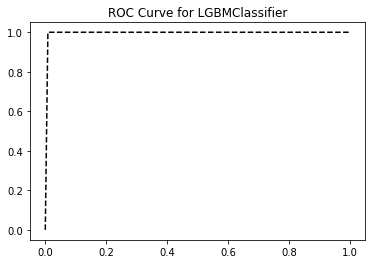

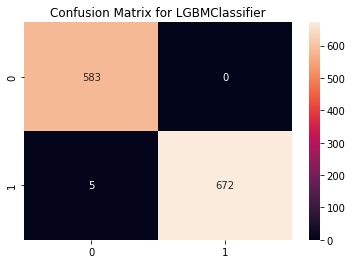

Time Spent = 9.994


In [12]:
lgb_reg = lgb.LGBMClassifier()

params = {"n_estimators":[50,250,500,1000],
         "learning_rate":[0.001,0.01,0.1],
         "max_depth":[-1,1,5,10]}

model_evaluation(lgb_reg, params, plot_cm=True, show_metrics=True)

#### EXTRA TREES

It is like random forest. But it selects sub samples without replacement. Extra Trees splits trees randomly. Extra Trees are faster than Random Forests.


**Source** 

- https://quantdare.com/what-is-the-difference-between-extra-trees-and-random-forest/

- https://stats.stackexchange.com/questions/175523/difference-between-random-forest-and-extremely-randomized-trees

- https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#:~:text=The%20Area%20Under%20the%20Curve,the%20positive%20and%20negative%20classes.

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

In [14]:
xclf = ExtraTreesClassifier()
params = {"n_estimators":[50,250,500,1000],
         "max_depth":[-1,1,5,10]}

FOR MODEL ExtraTreesClassifier
Pure Test Score = 0.989
Final score = 0.9873
Precision Score = 0.999
Recall Score = 0.993
F1 Score = 0.996
Roc Auc Score = 0.995


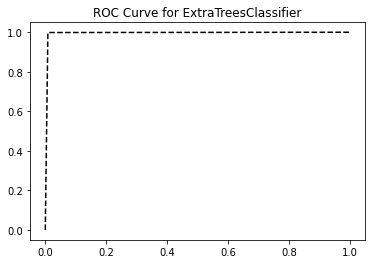

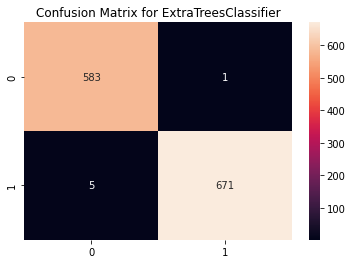

Time Spent = 33.628


In [15]:
model_evaluation(xclf, params, plot_cm=True, show_metrics=True)

#### PASSIVE-AGGRESSIVE LEARNING

Passive-Aggressive algorithms are generally used for large-scale learning.

In [16]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [17]:
pa_clf = PassiveAggressiveClassifier()

FOR MODEL PassiveAggressiveClassifier
Pure Test Score = 0.945
Final score = 0.9548
Precision Score = 0.888
Recall Score = 0.979
F1 Score = 0.931
Roc Auc Score = 0.933


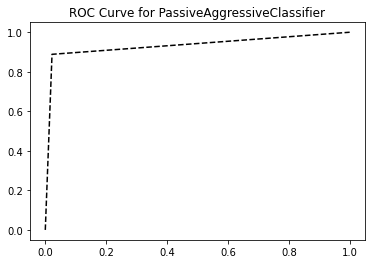

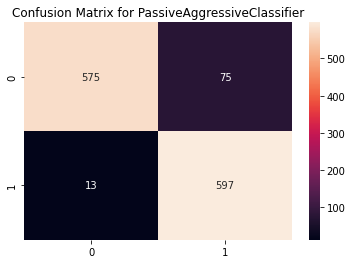

Time Spent = 1.378


In [18]:
params = {"C":[0.1,0.5,1],
          "max_iter":[5,50,100,500,1000],
          "tol":[0.001,0.01,0.1]}

model_evaluation(pa_clf, params, plot_cm=True, show_metrics=True)

**We can handle with recall score adjusting prediction probability threshold. I say this because this passive aggressive model predict 26 0s as 1s i.e. it says 26 anomalies are normal.**

#### KNN 

- https://www.youtube.com/watch?v=UqYde-LULfs&ab_channel=ThalesSehnK%C3%B6rting

- https://harshkr21august.medium.com/knn-and-kmeans-b741dfccb69#:~:text=K%2Dmeans%20is%20an%20unsupervised,K%2Dmeans%20and%20KNN%20algorithm.&text=It%20makes%20predictions%20by%20learning%20from%20the%20past%20available%20data.

In [19]:
from sklearn.neighbors import KNeighborsClassifier

Selecting optimal k cluster number.

In [20]:
x_train, y_train = df_train2.drop("class", axis=1), df_train2["class"]

x_test, y_test = df_test.drop("class", axis=1), df_test["class"]

y_test = [1 if i=="normal" else 0 for i in y_test]

In [21]:
k_values = []
score_knn = []
for i in range(1,25):
    knn_clf = KNeighborsClassifier(i)
    knn_clf.fit(x_train, y_train)
    y_pred = knn_clf.predict(x_test)
    y_pred = [1 if i=="normal" else 0 for i in y_pred]
    score_knn.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    k_values.append(i)

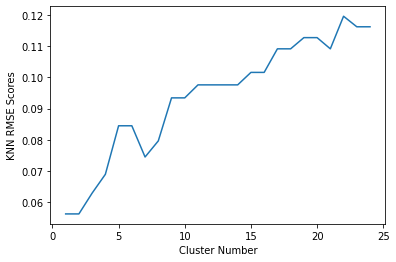

In [22]:
# 3 is optimal
plt.plot(k_values, score_knn)
#plt.gca().invert_yaxis()
plt.xlabel("Cluster Number")
plt.ylabel("KNN RMSE Scores")
plt.show()

In [23]:
params = {"p":[1,2], "leaf_size":[1,5,25]}

knn_clf = KNeighborsClassifier(n_neighbors=3)

FOR MODEL KNeighborsClassifier
Pure Test Score = 0.982
Final score = 0.9825
Precision Score = 0.997
Recall Score = 0.994
F1 Score = 0.996
Roc Auc Score = 0.995


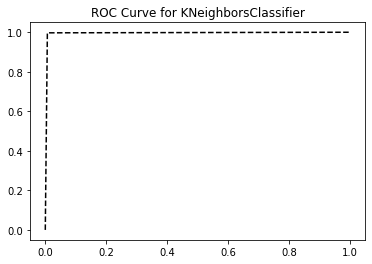

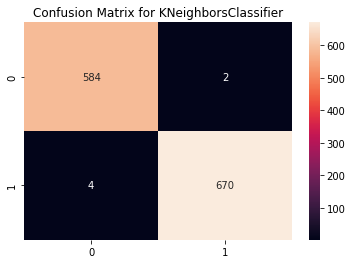

Time Spent = 9.869


In [24]:
model_evaluation(knn_clf, params, plot_cm=True, show_metrics=True)

#### NAIVE BAYES

Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem. We assume that no pair of features are dependent. Each feature is given the same weight(or importance).

- https://www.geeksforgeeks.org/naive-bayes-classifiers/

- https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c

In [25]:
from sklearn.naive_bayes import GaussianNB

In [26]:
gauss_nb = GaussianNB()

FOR MODEL GaussianNB
Pure Test Score = 0.82
Final score = 0.8016
Precision Score = 0.906
Recall Score = 0.892
F1 Score = 0.899
Roc Auc Score = 0.89


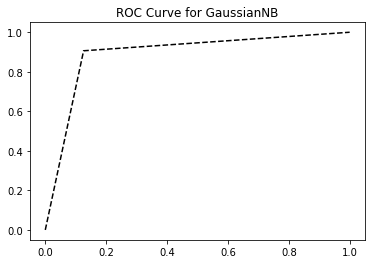

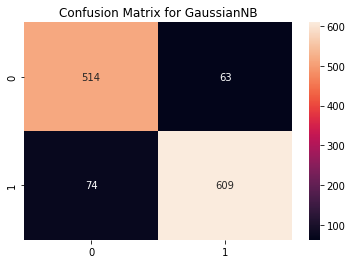

Time Spent = 0.65


In [27]:
params = {}

model_evaluation(gauss_nb, params, plot_cm=True, show_metrics=True)

#### SGD CLASSIFIER

If you are working on a large dataset.

In [28]:
from sklearn.linear_model import SGDClassifier

In [29]:
sgd_clf = SGDClassifier()

FOR MODEL SGDClassifier
Pure Test Score = 0.939
Final score = 0.9619
Precision Score = 0.921
Recall Score = 0.979
F1 Score = 0.949
Roc Auc Score = 0.95


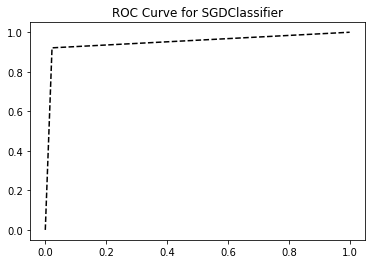

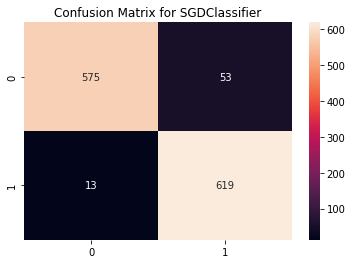

Time Spent = 1.717


In [30]:
params = {}

model_evaluation(sgd_clf, params, plot_cm=True, show_metrics=True)

#### PyOD XGBOD

In [31]:
from pyod.models import xgbod

In [32]:
xgbod_clf = xgbod.XGBClassifier()

[12:21:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:21:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

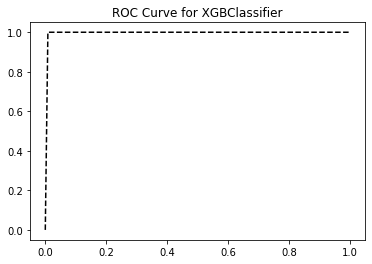

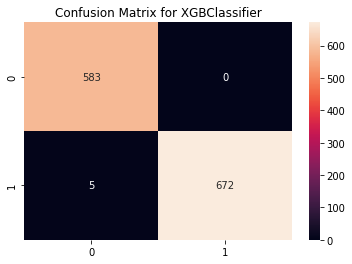

Time Spent = 6.547


In [33]:
params = {}

model_evaluation(xgbod_clf, params, plot_cm=True, show_metrics=True)

#### NEURAL NETWORK WITH PYTORCH

- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

- https://curiousily.com/posts/build-your-first-neural-network-with-pytorch/

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [ ]:
x_train, y_train = df_train2.drop("class", axis=1), df_train2["class"]
x_test, y_test = df_test.drop("class", axis=1), df_test["class"]
x_train = torch.from_numpy(x_train.to_numpy()).float()
x_test = torch.from_numpy(x_test.to_numpy()).float()
y_test = np.array([1 if i=="normal" else 0 for i in y_test])
y_train = np.array([1 if i=="normal" else 0 for i in y_train])
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))
net = Net(x_train.shape[1])

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

In [ ]:
net = net.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)


In [ ]:
for epoch in range(1000):
    y_pred = net(x_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(x_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

___

#### COMPARING MODELS

In [52]:
df_compare = pd.DataFrame(compare_dictionary).T
df_compare

,final_score,roc_auc_score,pure_score_wo_param,time
LogisticRegression,0.9548,0.961,0.956,3.225
LGBMClassifier,0.9913,0.996,0.992,9.994
ExtraTreesClassifier,0.9873,0.995,0.989,33.628
PassiveAggressiveClassifier,0.9548,0.933,0.945,1.378
KNeighborsClassifier,0.9825,0.995,0.982,9.869
GaussianNB,0.8016,0.890,0.820,0.650
SGDClassifier,0.9619,0.950,0.939,1.717
XGBClassifier,0.9897,0.996,0.992,6.547


Depending on metrics the **best algorithm is XGBClassifier** of PyOD library. It has the best pure score and depending on its score it is the fastest algorithm.